# SEM image segmentation with Neural Networks

## 1. Set up imports and parameters

In [1]:
import os
import imageio
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
import cv2

from PIL import Image
from Measurements import Measure
from HelperFunctions import *

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Path to images
IMAGE_DIR = os.path.join(ROOT_DIR, "Images")

# Local path to trained weights file
SEGMENTATION_MODEL_PATH = os.path.join(ROOT_DIR, "UNet_Masks_Manual.h5")
CLASSIFICATION_MODEL_PATH = os.path.join(ROOT_DIR, "ClassificationModel.h5")

# Set up global variables
IMAGE_SIZE_W = 1024
IMAGE_SIZE_H = 712
THRESHOLD = 0.5

# Uncomment to run on GPU (if CUDA is set up properly)
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use GPU 0

## 2. Create Model in inference mode and let it predict the images

c:\users\bruehle\appdata\local\programs\python\python38\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
c:\users\bruehle\appdata\local\programs\python\python38\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


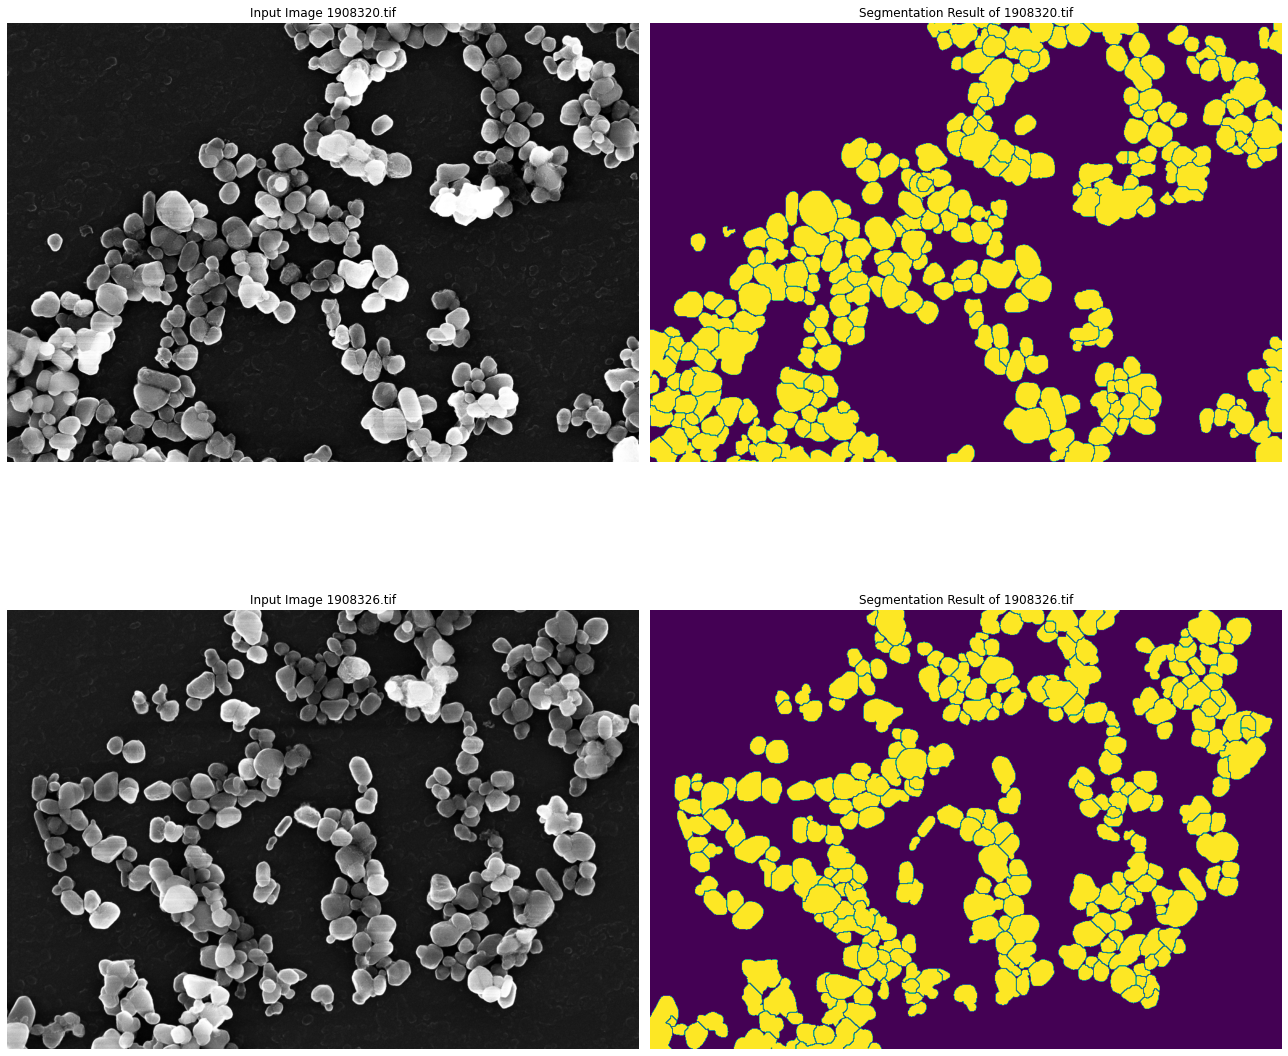

In [2]:
# Load Neural Network Models
segmentationModel = tf.keras.models.load_model(SEGMENTATION_MODEL_PATH, custom_objects={'weighted_bce': weighted_bce, 'weighted_cce': weighted_cce})
classificationModel = tf.keras.models.load_model(CLASSIFICATION_MODEL_PATH, custom_objects={'weighted_bce': weighted_bce, 'weighted_cce': weighted_cce})

# Get a list of Input Files
inputFiles = [os.path.join(IMAGE_DIR, file) for file in os.listdir(IMAGE_DIR) if '.tif' in file]

# Segment Input Files
rows = len(inputFiles)
cols = 2
fig = plt.figure(figsize=(18, 18*rows/cols))
output = []

for i, f in enumerate(inputFiles):
    # Read and crop image (remove black bar at bottom)
    image = np.asarray(Image.open(f), dtype='uint8').copy()
    image = image[0:IMAGE_SIZE_H, 0:IMAGE_SIZE_W]
    
    a = fig.add_subplot(rows, cols, 2*i+1)
    plt.axis('off')
    imgplot = plt.imshow(image, cmap="gray")
    a.set_title('Input Image ' + os.path.basename(f))

    # Preprocess image
    INPUT_SIZE_H = K.int_shape(segmentationModel.inputs[0])[1]
    INPUT_SIZE_W = K.int_shape(segmentationModel.inputs[0])[2]
    inp = preprocessImage(image, IMAGE_SIZE_W, IMAGE_SIZE_H, INPUT_SIZE_W, INPUT_SIZE_H, minOverlap=2)
    
    # Run inference
    out = segmentationModel.predict(inp)

    # Deprocess image
    out = deprocessImage(out, IMAGE_SIZE_W, IMAGE_SIZE_H, INPUT_SIZE_W, INPUT_SIZE_H, minOverlap=2, manageOverlapsMode=2, return8BitImage=False)

    # Run watershed segmentation
    seg = segment(out, threshold=THRESHOLD, watershedLines=True)
    
    a = fig.add_subplot(rows, cols, 2*i+2)
    plt.axis('off')
    imgplot = plt.imshow(seg)
    a.set_title('Segmentation Result of ' + os.path.basename(f))
    
    output.append([image, out, seg])

# Show results
plt.tight_layout()
plt.show()

## Run measurements and custom filters 

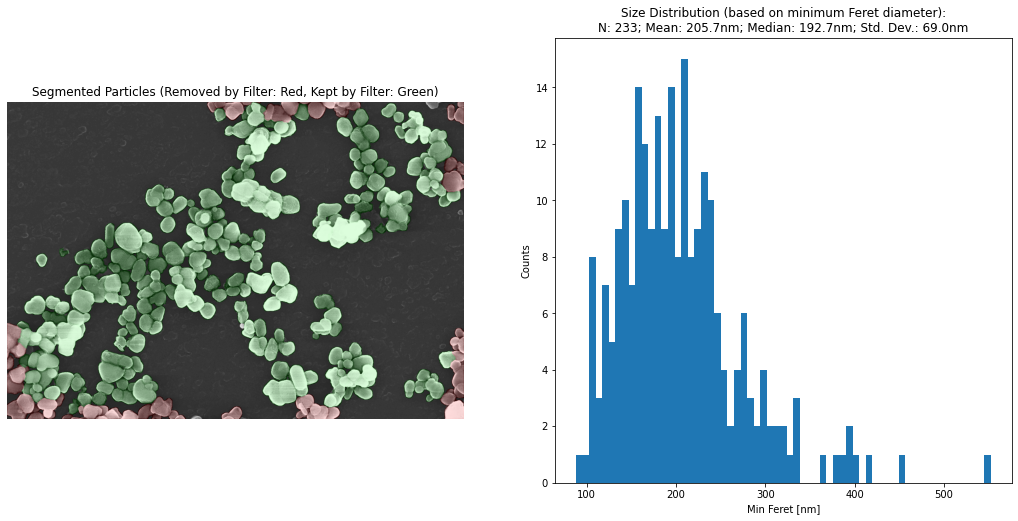

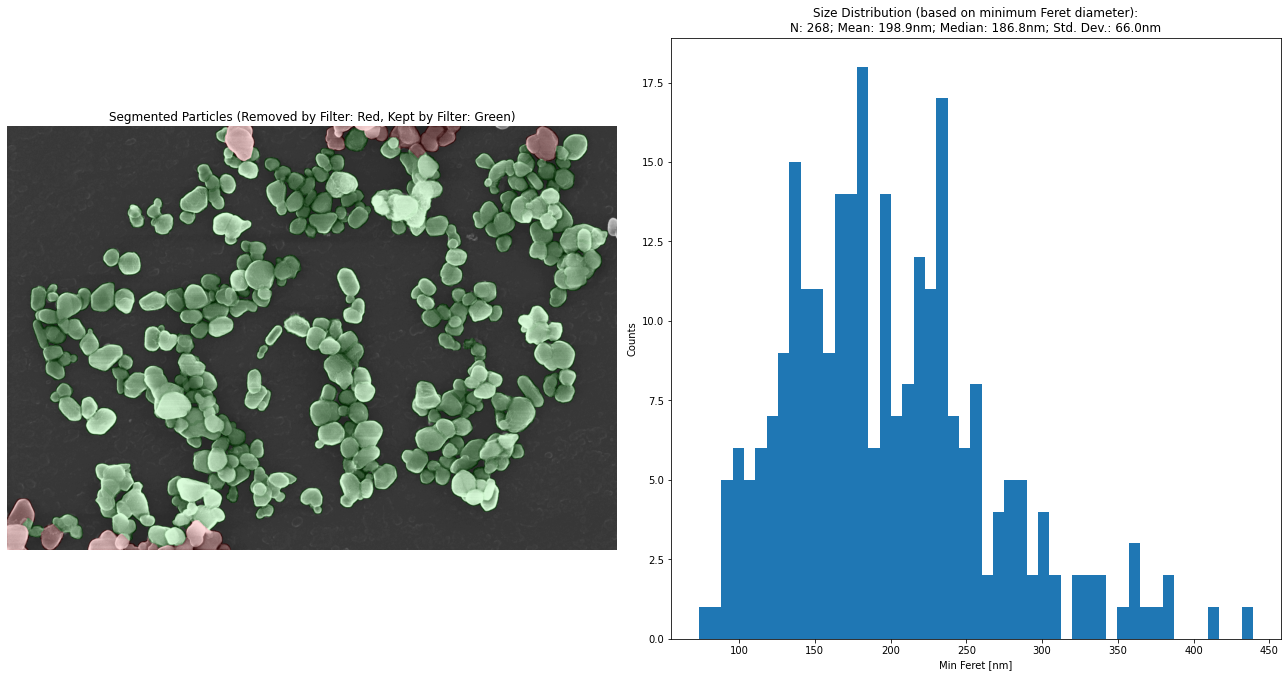

In [3]:
for i, o in enumerate(output):
    m = Measure(o[2], pixelDistance=1024, knownDistance=7520, unit='nm', darkBackground=True, threshold=1)

    # Measure some properties
    m.calculateMinFeretDiameters()
    m.calculateMaxFeretDiameters()

    # Filter based on Area (everything smaller than 3x3 pixels is likely a segmentation error)
    m.filterResults(filterType='area', minValue=9 * (m.knownDistance ** 2) / (m.pixelDistance ** 2))

    # Show original image with Contours overlaid, and min Feret Histogramm
    rows = len(output)
    cols = 2
    fig = plt.figure(figsize=(18, 18*rows/cols))

    # Original image with Contours overlaid
    canvas = cv2.cvtColor(src=o[0].copy(), code=cv2.COLOR_GRAY2RGBA)
    contours = np.zeros(canvas.shape, dtype='uint8')
    cv2.drawContours(image=contours, contours=m._allContours, contourIdx=-1, color=(255, 0, 0, 64), thickness=-1)
    cv2.drawContours(image=contours, contours=m._allContours, contourIdx=-1, color=(255, 0, 0, 255), thickness=2)
    cv2.drawContours(image=contours, contours=m.contours, contourIdx=-1, color=(0, 255, 0, 64), thickness=-1)
    cv2.drawContours(image=contours, contours=m.contours, contourIdx=-1, color=(0, 255, 0, 255), thickness=2)
    a = fig.add_subplot(rows, cols, 2*i+1)
    plt.axis('off')
    imgplot = plt.imshow(cv2.addWeighted(canvas, 0.85, contours, 0.15, 0))
    a.set_title('Segmented Particles (Removed by Filter: Red, Kept by Filter: Green)')

    # Histogram
    a = fig.add_subplot(rows, cols, 2*i+2)
    x = np.asarray(m.minFeretDiameters.copy())
    bins = int((np.max(x) - np.min(x))/(m.knownDistance/m.pixelDistance))  # bin size of 1 pixel
    plt.hist(x, bins=bins)
    stats = 'N: ' + str(m.number) + \
            '; Mean: ' + str(round(x.mean(), 1)) + m.unit + \
            '; Median: ' + str(round(float(np.median(x)), 1)) + m.unit + \
            '; Std. Dev.: ' + str(round(x.std())) + m.unit
    plt.gca().set(title=stats, xlabel='Min Feret [' + m.unit + ']', ylabel='Counts')
    a.set_title('Size Distribution (based on minimum Feret diameter):\n'+stats)

# Show results
plt.tight_layout()
plt.show()

## Run Measurements and Auto-Filter

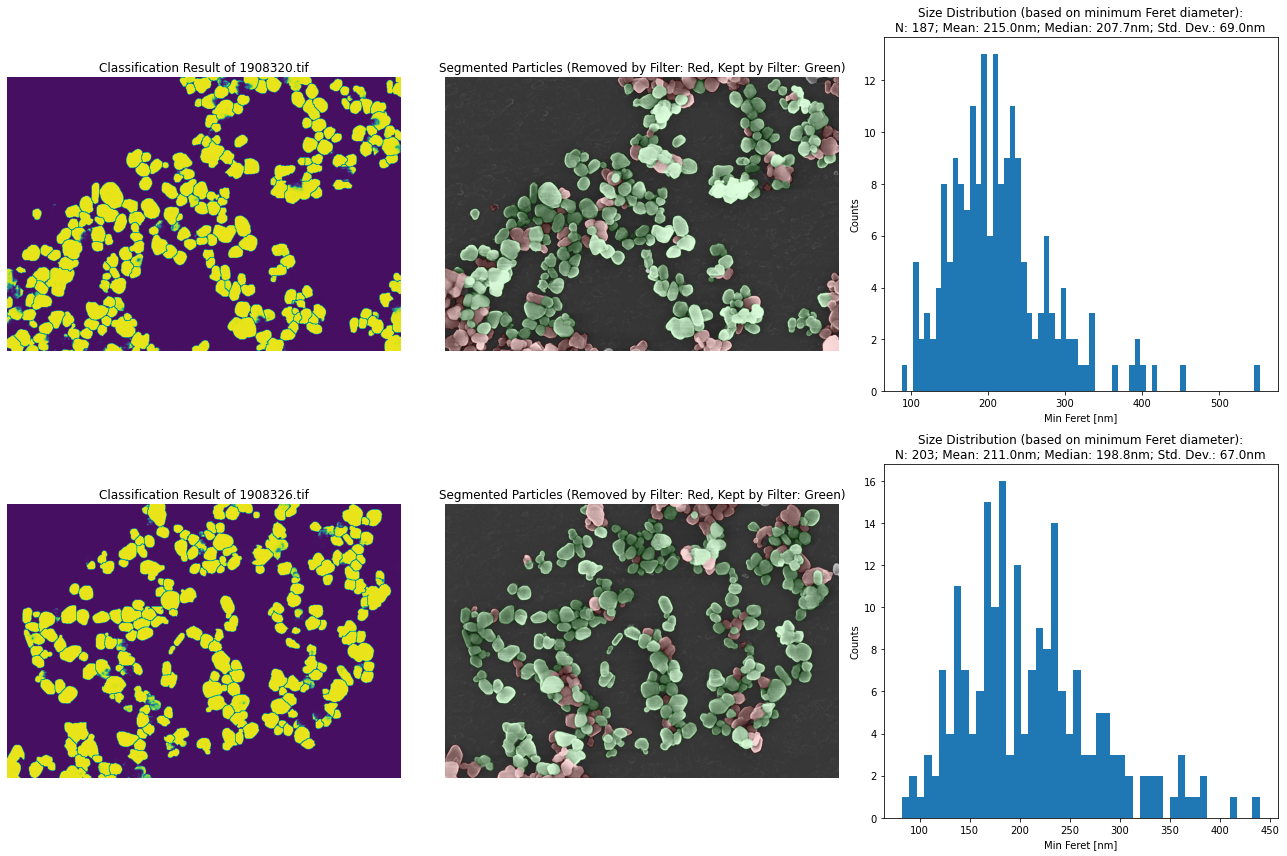

In [4]:
rows = len(inputFiles)
cols = 3
fig = plt.figure(figsize=(18, 18*rows/cols))

for i, o in enumerate(output):    
    # Run initial segmentation through second neural network for classification (if not done already)
    if len(o) < 4:
        # Preprocess images
        INPUT_SIZE_H = K.int_shape(classificationModel.inputs[0])[1]
        INPUT_SIZE_W = K.int_shape(classificationModel.inputs[0])[2]
        inp1 = preprocessImage(o[0], IMAGE_SIZE_W, IMAGE_SIZE_H, INPUT_SIZE_W, INPUT_SIZE_H, minOverlap=2)
        inp2 = preprocessImage(o[2], IMAGE_SIZE_W, IMAGE_SIZE_H, INPUT_SIZE_W, INPUT_SIZE_H, minOverlap=2)

        # Assemble input vector for second neural network    
        inp = np.concatenate((inp1, inp2), -1)

        # Run inference
        out = classificationModel.predict(inp)

        # Deprocess image
        out = deprocessImage(out, IMAGE_SIZE_W, IMAGE_SIZE_H, INPUT_SIZE_W, INPUT_SIZE_H)[:, :, 0]
        output[i].append(out)
    else:
        out = o[3]

    a = fig.add_subplot(rows, cols, 3*i+1)
    plt.axis('off')
    imgplot = plt.imshow(out)
    a.set_title('Classification Result of ' + os.path.basename(inputFiles[i]))
    
    # Measure classification output and filter based on mean intensities
    m = Measure(o[2], pixelDistance=1024, knownDistance=7520, unit='nm', darkBackground=True, threshold=1, grayscaleImage=out)

    # Measure some properties
    m.calculateMinFeretDiameters()
    m.calculateMeanIntensities()
    
    # Filter based on Mean Intensity (calculated taking calibration into account)
    m.filterResults(filterType='meanIntensity', minValue=0.5 / (m.knownDistance ** 2) * (m.pixelDistance ** 2))
    # Filter based on Area (everything smaller than 3x3 pixels is likely a segmentation error)
    m.filterResults(filterType='area', minValue=9 * (m.knownDistance ** 2) / (m.pixelDistance ** 2))
    
    # Original image with Contours overlaid
    canvas = cv2.cvtColor(src=o[0].copy(), code=cv2.COLOR_GRAY2RGBA)
    contours = np.zeros(canvas.shape, dtype='uint8')
    cv2.drawContours(image=contours, contours=m._allContours, contourIdx=-1, color=(255, 0, 0, 64), thickness=-1)
    cv2.drawContours(image=contours, contours=m._allContours, contourIdx=-1, color=(255, 0, 0, 255), thickness=2)
    cv2.drawContours(image=contours, contours=m.contours, contourIdx=-1, color=(0, 255, 0, 64), thickness=-1)
    cv2.drawContours(image=contours, contours=m.contours, contourIdx=-1, color=(0, 255, 0, 255), thickness=2)
    a = fig.add_subplot(rows, cols, 3*i+2)
    plt.axis('off')
    imgplot = plt.imshow(cv2.addWeighted(canvas, 0.85, contours, 0.15, 0))
    a.set_title('Segmented Particles (Removed by Filter: Red, Kept by Filter: Green)')

    # Histogram
    a = fig.add_subplot(rows, cols, 3*i+3)
    x = np.asarray(m.minFeretDiameters.copy())
    bins = int((np.max(x) - np.min(x))/(m.knownDistance/m.pixelDistance))  # bin size of 1 pixel
    plt.hist(x, bins=bins)
    stats = 'N: ' + str(m.number) + \
            '; Mean: ' + str(round(x.mean(), 1)) + m.unit + \
            '; Median: ' + str(round(float(np.median(x)), 1)) + m.unit + \
            '; Std. Dev.: ' + str(round(x.std())) + m.unit
    plt.gca().set(title=stats, xlabel='Min Feret [' + m.unit + ']', ylabel='Counts')
    a.set_title('Size Distribution (based on minimum Feret diameter):\n'+stats)
    
# Show results
plt.tight_layout()
plt.show()